**Importing the Libraries**

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
!pip install pmdarima
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error,mean_absolute_error,median_absolute_error,r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tenorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import LabelEncoder
import plotly.graph_objects as go
import prophet
from statsmodels.tsa.api import VAR
from statsmodels.tsa.ar_model import AutoReg

**Read The Dataset**

In [2]:
df = pd.read_csv(r"/content/insurance_unemployed_data.csv")

In [3]:
df.head()


,Year,Month,Region,County,Beneficiaries,Benefit Amounts (Dollars)
0,2018,11,Capital,Albany,1600,1570000
1,2018,11,Western New York,Allegany,400,300000
2,2018,11,New York City,Bronx,11600,11530000
3,2018,11,Southern Tier,Broome,1400,1150000
4,2018,11,Western New York,Cattaraugus,900,710000


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13760 entries, 0 to 13759
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Year                         13760 non-null  int64 
 1   Month                        13760 non-null  int64 
 2   Region                       13760 non-null  object
 3   County                       13760 non-null  object
 4   Beneficiaries                13760 non-null  int64 
 5    Benefit Amounts (Dollars)   13760 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 645.1+ KB


In [5]:
df.shape

(13760, 6)

**`Checking for missing values`**

In [6]:
print(df.isnull().sum())


Year                           0
Month                          0
Region                         0
County                         0
Beneficiaries                  0
 Benefit Amounts (Dollars)     0
dtype: int64


**Checking for Duplicates**

In [7]:
df.duplicated().sum()

0

**Descriptive Analysis**

In [8]:
df.describe()

,Year,Month,Beneficiaries,Benefit Amounts (Dollars)
count,13760.000000,13760.000000,13760.000000,1.376000e+04
mean,2009.460465,6.474419,3858.335756,3.846968e+06
std,5.167803,3.439709,6557.550710,6.878640e+06
min,2001.000000,1.000000,0.000000,0.000000e+00
25%,2005.000000,3.000000,600.000000,5.700000e+05
50%,2009.000000,6.000000,1200.000000,1.110000e+06
75%,2014.000000,9.000000,2800.000000,2.720000e+06
max,2018.000000,12.000000,50700.000000,5.681000e+07


**Splitting Dataset into Train and Test Sets**

In [9]:
df.dropna(inplace=True)

In [10]:
train_size=int (len(df)*0.8)
train,test=df[:train_size],df[train_size:]

**create differenced column**

In [11]:
train['Beneficiaries_diff']=train['Beneficiaries'].diff()
print(train['Beneficiaries_diff'])

0            NaN
1        -1200.0
2        11200.0
3       -10200.0
4         -500.0
          ...   
11003        0.0
11004      500.0
11005     6700.0
11006    -7300.0
11007     -200.0
Name: Beneficiaries_diff, Length: 11008, dtype: float64


In [12]:
df.describe()

,Year,Month,Beneficiaries,Benefit Amounts (Dollars)
count,13760.000000,13760.000000,13760.000000,1.376000e+04
mean,2009.460465,6.474419,3858.335756,3.846968e+06
std,5.167803,3.439709,6557.550710,6.878640e+06
min,2001.000000,1.000000,0.000000,0.000000e+00
25%,2005.000000,3.000000,600.000000,5.700000e+05
50%,2009.000000,6.000000,1200.000000,1.110000e+06
75%,2014.000000,9.000000,2800.000000,2.720000e+06
max,2018.000000,12.000000,50700.000000,5.681000e+07


In [13]:
df

,Year,Month,Region,County,Beneficiaries,Benefit Amounts (Dollars)
0,2018,11,Capital,Albany,1600,1570000
1,2018,11,Western New York,Allegany,400,300000
2,2018,11,New York City,Bronx,11600,11530000
3,2018,11,Southern Tier,Broome,1400,1150000
4,2018,11,Western New York,Cattaraugus,900,710000
...,...,...,...,...,...,...
13755,2001,1,Capital,Washington,900,750000
13756,2001,1,Finger Lakes,Wayne,1700,1460000
13757,2001,1,Hudson Valley,Westchester,8000,8610000
13758,2001,1,Finger Lakes,Wyoming,1000,990000


**Model Building**

**Augmented Dickey_Fuller Test**

In [14]:
from statsmodels.tsa.stattools import adfuller

In [15]:
adf=adfuller(df['Beneficiaries'],autolag='AIC')
print("P-Value",adf[1])

P-Value 1.1707826460144518e-28


In [16]:
#adf=adfuller(df['Beneficiaries'],autolag='AIC')#

#print("P-Value",adf[1])#


In [17]:
adf=adfuller(train['Beneficiaries_diff'].dropna())       #drops NaN Values
print("P-Value",adf[1])

P-Value 0.0


In [18]:
# Replace infinite values with NaN
#train['Beneficiaries_diff'] = train['Beneficiaries_diff'].replace([np.inf, -np.inf], np.nan)

# Drop rows with NaN values
#train.dropna(subset=['Beneficiaries_diff'], inplace=True)

# Perform the Augmented Dickey-Fuller test
#adf = adfuller(train['Beneficiaries_diff'], autolag='AIC')
#print("P-Value", adf[1])

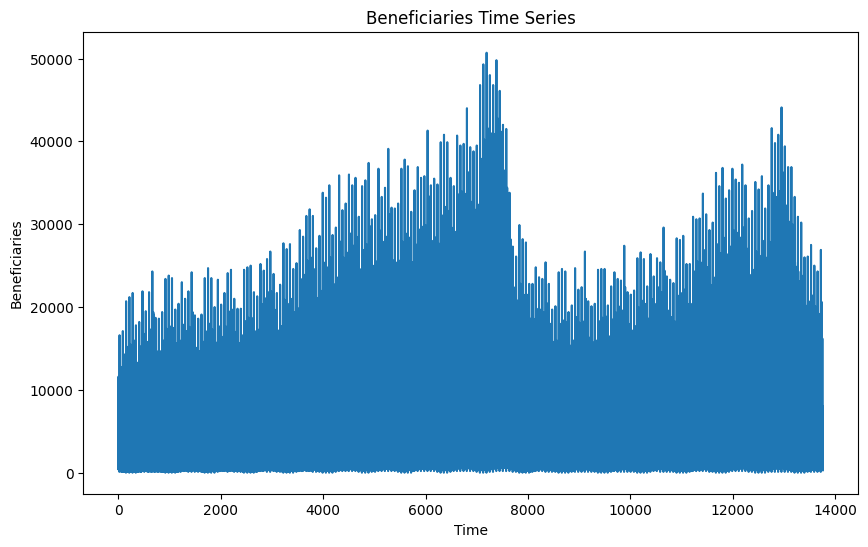

In [19]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.plot(df['Beneficiaries'])

plt.title('Beneficiaries Time Series')

plt.xlabel('Time')

plt.ylabel('Beneficiaries')

plt.show()

Smoothing Data

**ACF and PACF**

In [20]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

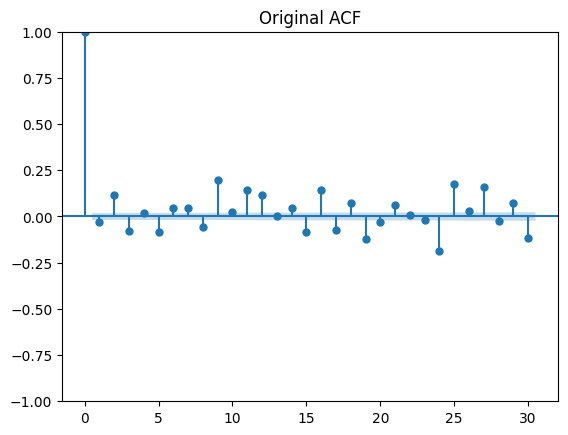

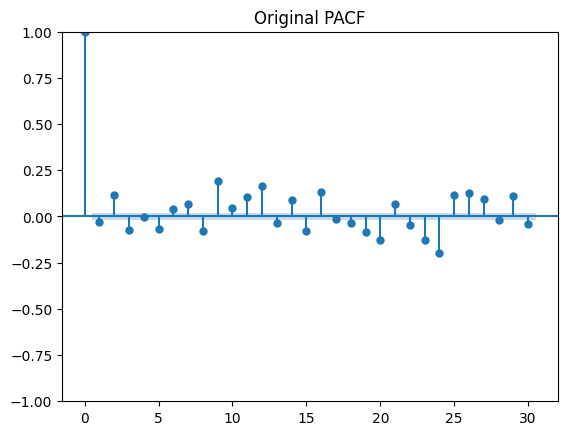

In [21]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(train['Beneficiaries'], lags=30,title='Original ACF')
plot_pacf(train['Beneficiaries'], lags=30,title='Original PACF')
plt.show()

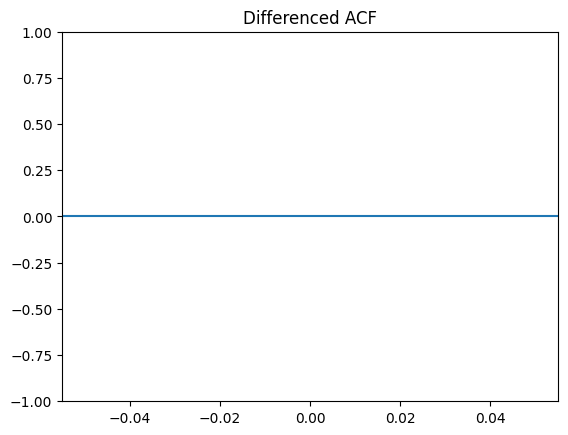

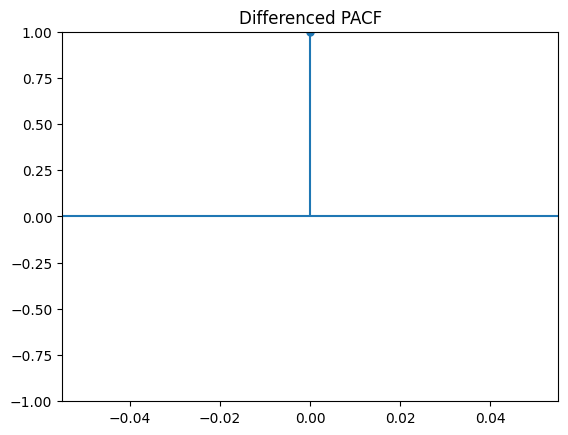

In [22]:
plot_acf(train['Beneficiaries_diff'], lags=30,title='Differenced ACF')
plot_pacf(train['Beneficiaries_diff'], lags=30,title='Differenced PACF')
plt.show()

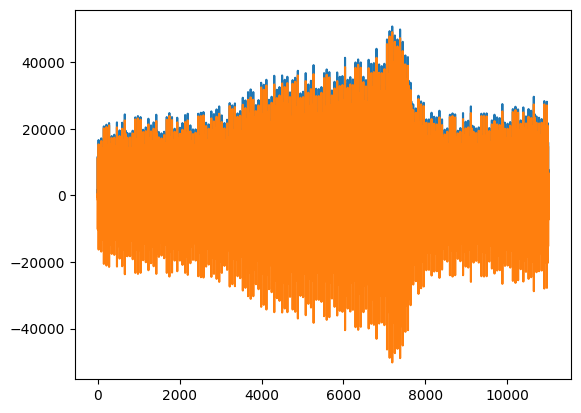

In [23]:
plt.plot(train['Beneficiaries'])
plt.plot(train['Beneficiaries_diff'])
plt.show()

**ARIMA**

In [24]:
from pmdarima import auto_arima

In [25]:
# Assuming 'Beneficiaries_diff' is calculated on the 'Beneficiaries' column of 'df'
df['Beneficiaries_diff'] = df['Beneficiaries'].diff()  # Calculate the difference and assign it to df

# Drop the first row containing the NaN value
df.dropna(subset=['Beneficiaries_diff'], inplace=True)

# Now run auto_arima
stepwise = auto_arima(df['Beneficiaries_diff'], trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=46.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=290888.756, Time=0.45 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=285462.262, Time=0.96 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=14.38 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=290886.756, Time=0.53 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=284658.918, Time=2.92 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=283770.788, Time=3.15 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=283484.214, Time=4.51 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=282830.565, Time=3.74 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=43.75 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=37.06 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=282828.565, Time=2.47 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=283482.214, Time=1.05 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=9.28 sec
 ARIMA(4,0,1)(0,0,0)[0]             

In [26]:
plt.show()

pass these values into the ARIMA model and build the model

In [27]:
!pip install statsmodels
from statsmodels.tsa.arima.model import ARIMA

# Assuming 'Beneficiaries_diff' is calculated on the 'Beneficiaries' column of 'df'
# ... (Your existing code for calculating Beneficiaries_diff) ...

# Now, you can use ARIMA
model = ARIMA(train['Beneficiaries_diff'], order=(5, 0, 0))
model_arima = model.fit()

In [28]:
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     Beneficiaries_diff   No. Observations:                11008
Model:                 ARIMA(5, 0, 0)   Log Likelihood             -112883.845
Date:                Tue, 03 Dec 2024   AIC                         225781.690
Time:                        04:18:40   BIC                         225832.834
Sample:                             0   HQIC                        225798.919
                              - 11008                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1272     21.475     -0.006      0.995     -42.218      41.963
ar.L1         -0.8365      0.013    -63.908      0.000      -0.862      -0.811
ar.L2         -0.5560      0.016    -35.844      0.000      -0.586      -0.526
ar.L3         -0.4685      0.014    -34.636      0.000      -0.495      -0.442
ar.L4         -0.3228      0.015    -21.196      0.000      -0.353      -0.293
ar.L5         -0.2190      0.011    -19.783      0.000      -0.241      -0.197
sigma2      4.737e+07      0.001   4.15e+10      0.000    4.74e+07    4.74e+07
===================================================================================
Ljung-Box (L1) (Q):                  22.29   Jarque-Bera (JB):             33235.45
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.40   Skew:                             2.40
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.17e+24. Standard errors may be unstable.
"""

**SARIMA**

In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [30]:
model=SARIMAX(train['Beneficiaries_diff'], order = (5,0,0),seasonal_order=(0,1,2,3))

In [31]:
model_sarima=model.fit()

from stats model library we imported the SARIMA and built the model

In [32]:
model_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                     Beneficiaries_diff   No. Observations:                11008
Model:             SARIMAX(5, 0, 0)x(0, 1, [1, 2], 3)   Log Likelihood             -112887.269
Date:                                Tue, 03 Dec 2024   AIC                         225790.538
Time:                                        04:20:01   BIC                         225848.987
Sample:                                             0   HQIC                        225810.229
                                              - 11008                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0204      0.035    -29.207      0.000      -1.089      -0.952
ar.L2         -0.9207      0.039    -23.789      0.000      -0.997      -0.845
ar.L3         -0.0298      0.035     -0.853      0.394      -0.098       0.039
ar.L4          0.0337      0.045      0.753      0.452      -0.054       0.121
ar.L5         -0.1015      0.039     -2.577      0.010      -0.179      -0.024
ma.S.L3       -1.9939      0.002  -1032.501      0.000      -1.998      -1.990
ma.S.L6        0.9941      0.002    514.644      0.000       0.990       0.998
sigma2       7.82e+07   1.87e-09   4.19e+16      0.000    7.82e+07    7.82e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):             29518.84
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               1.43   Skew:                             2.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.27e+31. Standard errors may be unstable.
"""

**AUTO REGRESSION**

In [33]:
#from statsmodels.tsa.ar_model import AutoReg#

In [34]:
#model_ar=AutoReg(train['Beneficiaries_diff'],lags=10).fit()#

In [35]:
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg

# Replace infinite values with NaN
train['Beneficiaries_diff'] = train['Beneficiaries_diff'].replace([np.inf, -np.inf], np.nan)

# Drop rows with missing values
train = train.dropna(subset=['Beneficiaries_diff'])

# Fit the AutoReg model
model_ar = AutoReg(train['Beneficiaries_diff'], lags=10).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [36]:
model_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:     Beneficiaries_diff   No. Observations:                11007
Model:                    AutoReg(10)   Log Likelihood             -111831.450
Method:               Conditional MLE   S.D. of innovations           6312.773
Date:                Tue, 03 Dec 2024   AIC                         223686.900
Time:                        04:20:01   BIC                         223774.565
Sample:                            10   HQIC                        223716.434
                                11007                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.0141     60.198     -0.000      1.000    -118.000     117.972
Beneficiaries_diff.L1     -0.9574      0.009   -101.734      0.000      -0.976      -0.939
Beneficiaries_diff.L2     -0.8113      0.013    -63.106      0.000      -0.837      -0.786
Beneficiaries_diff.L3     -0.8197      0.014    -57.846      0.000      -0.847      -0.792
Beneficiaries_diff.L4     -0.7496      0.015    -48.565      0.000      -0.780      -0.719
Beneficiaries_diff.L5     -0.7656      0.016    -48.026      0.000      -0.797      -0.734
Beneficiaries_diff.L6     -0.6221      0.016    -39.021      0.000      -0.653      -0.591
Beneficiaries_diff.L7     -0.5102      0.015    -33.056      0.000      -0.540      -0.480
Beneficiaries_diff.L8     -0.5172      0.014    -36.502      0.000      -0.545      -0.489
Beneficiaries_diff.L9     -0.2697      0.013    -20.980      0.000      -0.295      -0.245
Beneficiaries_diff.L10    -0.1618      0.009    -17.190      0.000      -0.180      -0.143
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             0.8870           -0.6690j            1.1110           -0.1029
AR.2             0.8870           +0.6690j            1.1110            0.1029
AR.3             0.4171           -1.1018j            1.1781           -0.1924
AR.4             0.4171           +1.1018j            1.1781            0.1924
AR.5            -1.0676           -0.3136j            1.1127           -0.4545
AR.6            -1.0676           +0.3136j            1.1127            0.4545
AR.7            -0.7111           -1.0654j            1.2809           -0.3437
AR.8            -0.7111           +1.0654j            1.2809            0.3437
AR.9            -0.3590           -1.2835j            1.3328           -0.2934
AR.10           -0.3590           +1.2835j            1.3328            0.2934
------------------------------------------------------------------------------
"""

In [37]:
df.head()

,Year,Month,Region,County,Beneficiaries,Benefit Amounts (Dollars),Beneficiaries_diff
1,2018,11,Western New York,Allegany,400,300000,-1200.0
2,2018,11,New York City,Bronx,11600,11530000,11200.0
3,2018,11,Southern Tier,Broome,1400,1150000,-10200.0
4,2018,11,Western New York,Cattaraugus,900,710000,-500.0
5,2018,11,Central New York,Cayuga,700,550000,-200.0


In [38]:
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-01', format='%Y-%m-%d')

In [39]:
df = df.drop(['Year', 'Month'], axis=1)

In [40]:
import pandas as pd

# Print the columns to verify their actual names
print(df.columns)

# Assuming 'Year' and 'Month' are the actual column names
# If they are different, update the code below with correct names
# For example, if the year column is named 'year_col', use:
# df['Date'] = pd.to_datetime(df['year_col'].astype(str) + '-' + df['month_col'].astype(str) + '-01', format='%Y-%m-%d')
if 'Year' in df.columns and 'Month' in df.columns:
  df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-01', format='%Y-%m-%d')
  df = df.drop(['Year', 'Month'], axis=1)  # if you want to drop the columns
else:
  print("Columns 'Year' and/or 'Month' not found in the DataFrame. Please check the column names.")

print(df)

Index(['Region', 'County', 'Beneficiaries', ' Benefit Amounts (Dollars) ',
       'Beneficiaries_diff', 'Date'],
      dtype='object')
Columns 'Year' and/or 'Month' not found in the DataFrame. Please check the column names.
                 Region       County  Beneficiaries  \
1      Western New York     Allegany            400   
2         New York City        Bronx          11600   
3         Southern Tier       Broome           1400   
4      Western New York  Cattaraugus            900   
5      Central New York       Cayuga            700   
...                 ...          ...            ...   
13755           Capital   Washington            900   
13756      Finger Lakes        Wayne           1700   
13757     Hudson Valley  Westchester           8000   
13758      Finger Lakes      Wyoming           1000   
13759      Finger Lakes        Yates            300   

        Benefit Amounts (Dollars)   Beneficiaries_diff       Date  
1                           300000             

In [41]:
df.head()

,Region,County,Beneficiaries,Benefit Amounts (Dollars),Beneficiaries_diff,Date
1,Western New York,Allegany,400,300000,-1200.0,2018-11-01
2,New York City,Bronx,11600,11530000,11200.0,2018-11-01
3,Southern Tier,Broome,1400,1150000,-10200.0,2018-11-01
4,Western New York,Cattaraugus,900,710000,-500.0,2018-11-01
5,Central New York,Cayuga,700,550000,-200.0,2018-11-01


**Prophet** Forecasting Model

For building the model we have to change our column names. date column should be as ds and the target column-Beneficiaries should be as y as per the model requirements.

In [42]:
df1=df[['Beneficiaries','Date']]

In [43]:
df1.rename(columns={'Date':'ds','Beneficiaries':'y'},inplace=True)

In [44]:
#df1=df1.set_index()

In [45]:
df1 = df1.reset_index()


In [46]:
df1

,index,y,ds
0,1,400,2018-11-01
1,2,11600,2018-11-01
2,3,1400,2018-11-01
3,4,900,2018-11-01
4,5,700,2018-11-01
...,...,...,...
13754,13755,900,2001-01-01
13755,13756,1700,2001-01-01
13756,13757,8000,2001-01-01
13757,13758,1000,2001-01-01


In [47]:
print(df1.head)


<bound method NDFrame.head of        index      y         ds
0          1    400 2018-11-01
1          2  11600 2018-11-01
2          3   1400 2018-11-01
3          4    900 2018-11-01
4          5    700 2018-11-01
...      ...    ...        ...
13754  13755    900 2001-01-01
13755  13756   1700 2001-01-01
13756  13757   8000 2001-01-01
13757  13758   1000 2001-01-01
13758  13759    300 2001-01-01

[13759 rows x 3 columns]>


In [48]:
train_size=int (len(df1) * 0.8)
train, test= df1[:train_size],df1[train_size:]

In [49]:
test

,index,y,ds
11007,11008,2200,2004-07-01
11008,11009,600,2004-07-01
11009,11010,15500,2004-07-01
11010,11011,1900,2004-07-01
11011,11012,1300,2004-07-01
...,...,...,...
13754,13755,900,2001-01-01
13755,13756,1700,2001-01-01
13756,13757,8000,2001-01-01
13757,13758,1000,2001-01-01


In [50]:
train

,index,y,ds
0,1,400,2018-11-01
1,2,11600,2018-11-01
2,3,1400,2018-11-01
3,4,900,2018-11-01
4,5,700,2018-11-01
...,...,...,...
11002,11003,500,2004-08-01
11003,11004,1000,2004-08-01
11004,11005,7700,2004-08-01
11005,11006,400,2004-08-01


Now imported the Library of prophet and built the model.



In [51]:
import prophet

In [52]:
model_prophet = prophet.Prophet(changepoint_prior_scale=0.05, seasonality_prior_scale=15, seasonality_mode='multiplicative')

In [53]:
model_prophet.add_country_holidays(country_name='US')

In [54]:
train = train.rename(columns={'Date': 'ds', 'Beneficiaries': 'y'})

In [55]:
df1.head()

,index,y,ds
0,1,400,2018-11-01
1,2,11600,2018-11-01
2,3,1400,2018-11-01
3,4,900,2018-11-01
4,5,700,2018-11-01


In [56]:
train

,index,y,ds
0,1,400,2018-11-01
1,2,11600,2018-11-01
2,3,1400,2018-11-01
3,4,900,2018-11-01
4,5,700,2018-11-01
...,...,...,...
11002,11003,500,2004-08-01
11003,11004,1000,2004-08-01
11004,11005,7700,2004-08-01
11005,11006,400,2004-08-01


In [57]:
model_prophet.fit(train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaw65i04m/v6xke9a9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaw65i04m/nvpvcsgq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76984', 'data', 'file=/tmp/tmpaw65i04m/v6xke9a9.json', 'init=/tmp/tmpaw65i04m/nvpvcsgq.json', 'output', 'file=/tmp/tmpaw65i04m/prophet_modelo9v_s65n/prophet_model-20241203042005.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:20:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:20:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


T**esting the models and evaluating the metrics**

**ARIMA**

In [58]:
!pip install statsmodels
from statsmodels.tsa.arima.model import ARIMA

# Assuming 'y' is the column in your DataFrame containing the time series data
# Define and fit the ARIMA model
# Replace (p, d, q) with appropriate values for your data
model = ARIMA(train['y'], order=(5, 1, 0))
model_fit = model.fit()

# Now you can make predictions
predictions_arima = model_fit.predict(start=len(train), end=len(train) + len(test)-1, typ='levels')
predictions_arima

,predicted_mean
11007,1126.169601
11008,1610.260738
11009,1673.391552
11010,2581.061627
11011,1304.606964
...,...
13754,1632.686511
13755,1632.686511
13756,1632.686511
13757,1632.686511


In Time Series while we are testing the model you have to pass some starting and ending parameters and then give the type. Here we gave to the arima model and we predicted the future.



In [59]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score

In [60]:
mean_squared_error(test['y'], predictions_arima)

55678693.1990747

In [61]:
mean_absolute_error(test['y'], predictions_arima)

3442.001494456475

In [62]:
median_absolute_error(test['y'], predictions_arima)

932.686511014218

In [63]:
r2_score(test['y'],predictions_arima)

-0.1306393311185059

In [64]:
train

,index,y,ds
0,1,400,2018-11-01
1,2,11600,2018-11-01
2,3,1400,2018-11-01
3,4,900,2018-11-01
4,5,700,2018-11-01
...,...,...,...
11002,11003,500,2004-08-01
11003,11004,1000,2004-08-01
11004,11005,7700,2004-08-01
11005,11006,400,2004-08-01


In [65]:
test

,index,y,ds
11007,11008,2200,2004-07-01
11008,11009,600,2004-07-01
11009,11010,15500,2004-07-01
11010,11011,1900,2004-07-01
11011,11012,1300,2004-07-01
...,...,...,...
13754,13755,900,2001-01-01
13755,13756,1700,2001-01-01
13756,13757,8000,2001-01-01
13757,13758,1000,2001-01-01


After importing the regression metrics to comprehend the model, upon examining the errors, it appears that they are quite substantial. However, upon logical consideration, these errors seem reasonable. Given that we are attempting to predict the future of 20% of the data from the total 100%, the extended duration for computation is understandable, and thus, the observed numbers seem justified.



**SARIMA**

In [66]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,median_absolute_error,r2_score

In [67]:
mean_squared_error(test['y'],predictions_arima)

55678693.1990747

In [68]:
mean_absolute_error(test['y'],predictions_arima)

3442.001494456475

In [69]:
median_absolute_error(test['y'],predictions_arima)

932.686511014218

In [70]:
r2_score(test['y'],predictions_arima)

-0.1306393311185059

In [71]:
train

,index,y,ds
0,1,400,2018-11-01
1,2,11600,2018-11-01
2,3,1400,2018-11-01
3,4,900,2018-11-01
4,5,700,2018-11-01
...,...,...,...
11002,11003,500,2004-08-01
11003,11004,1000,2004-08-01
11004,11005,7700,2004-08-01
11005,11006,400,2004-08-01


In [72]:
test

,index,y,ds
11007,11008,2200,2004-07-01
11008,11009,600,2004-07-01
11009,11010,15500,2004-07-01
11010,11011,1900,2004-07-01
11011,11012,1300,2004-07-01
...,...,...,...
13754,13755,900,2001-01-01
13755,13756,1700,2001-01-01
13756,13757,8000,2001-01-01
13757,13758,1000,2001-01-01


After conducting predictions and testing with the SARIMA model, we've observed significant numbers. Let's explore alternative models and then determine the most suitable one among them.



**AR**

In [73]:
predictions_ar= model_ar.predict(start=len(train),end=len(train)+len(test)-1)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [74]:
mean_squared_error(test['y'],predictions_ar)

66629861.840326734

In [75]:
mean_absolute_error(test['y'],predictions_ar)

4169.10549719546

In [76]:
median_absolute_error(test['y'],predictions_ar)

1400.001960657321

In [77]:
r2_score(test['y'],predictions_ar)

-0.35301922683985376

In [78]:
train

,index,y,ds
0,1,400,2018-11-01
1,2,11600,2018-11-01
2,3,1400,2018-11-01
3,4,900,2018-11-01
4,5,700,2018-11-01
...,...,...,...
11002,11003,500,2004-08-01
11003,11004,1000,2004-08-01
11004,11005,7700,2004-08-01
11005,11006,400,2004-08-01


In [79]:
test

,index,y,ds
11007,11008,2200,2004-07-01
11008,11009,600,2004-07-01
11009,11010,15500,2004-07-01
11010,11011,1900,2004-07-01
11011,11012,1300,2004-07-01
...,...,...,...
13754,13755,900,2001-01-01
13755,13756,1700,2001-01-01
13756,13757,8000,2001-01-01
13757,13758,1000,2001-01-01


So far, based on our observations of the models, AR stands out as a potential candidate.



**VAR**

In [80]:
# Assuming 'y' is the only column used for forecasting:
#predictions_var = model_ar.forecast(train[['y']].values, steps=5)

In [81]:
predictions_var = model_ar.predict(start=len(train), end=len(train) + 4, dynamic=False)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


From the VAR model we have seen plenty of metrics that are helping us to understand the model. so here let’s just predict the model. For prediction the VAR model this the code we have to write.


**Prophet**

In [82]:
future=model_prophet.make_future_dataframe(periods=len(test),freq='M')

In [83]:
forecast=model_prophet.predict(future)

In [84]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2004-08-01,3261.219091,-4919.844915,11542.036666
1,2004-09-01,3145.418930,-5408.708290,11161.504688
2,2004-10-01,2772.032010,-5385.067928,11039.911354
3,2004-11-01,3003.162440,-5181.727575,11084.133967
4,2004-12-01,3382.859630,-4629.032788,11784.762209


We are predicting the prophet model. here once we predicted future values taking the only important features.

Let us visualise our forecasting for our better understanding.



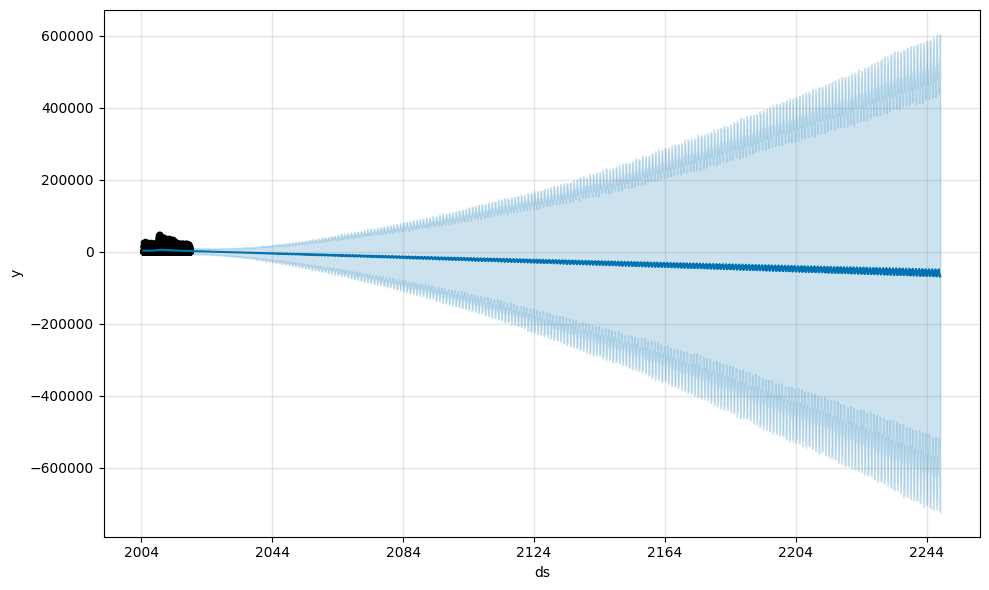

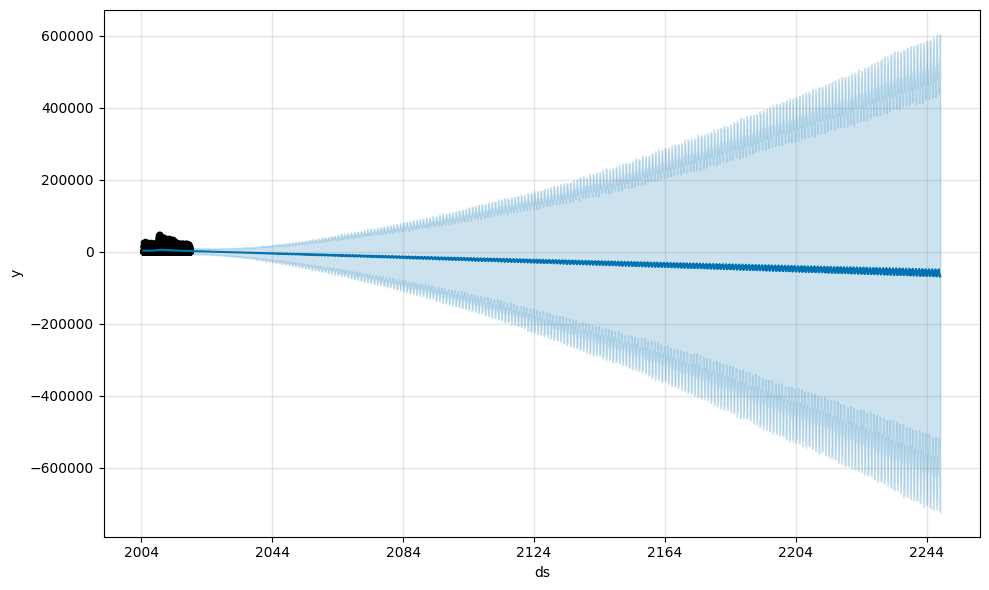

In [85]:
model_prophet.plot(forecast)

Let us see how our model is performing



In [86]:
actual_values=test['y']
predicted_values=forecast[-len(test):]['yhat'].values

In [87]:
mae=mean_squared_error(actual_values,predicted_values)
mse=mean_squared_error(actual_values,predicted_values)
rmse=np.sqrt(mean_squared_error(actual_values,predicted_values))
r2=r2_score(actual_values,predicted_values)

In [88]:
print("Mean Absolute Error:",mae)
print("Mean Squared Error:",mse)
print("Root Mean Squared Error:",rmse)
print("R-squared:",r2)

Mean Absolute Error: 1434708096.538701
Mean Squared Error: 1434708096.538701
Root Mean Squared Error: 37877.54079317585
R-squared: -28.133898613981465


In [89]:
train

,index,y,ds
0,1,400,2018-11-01
1,2,11600,2018-11-01
2,3,1400,2018-11-01
3,4,900,2018-11-01
4,5,700,2018-11-01
...,...,...,...
11002,11003,500,2004-08-01
11003,11004,1000,2004-08-01
11004,11005,7700,2004-08-01
11005,11006,400,2004-08-01


In [90]:
test

,index,y,ds
11007,11008,2200,2004-07-01
11008,11009,600,2004-07-01
11009,11010,15500,2004-07-01
11010,11011,1900,2004-07-01
11011,11012,1300,2004-07-01
...,...,...,...
13754,13755,900,2001-01-01
13755,13756,1700,2001-01-01
13756,13757,8000,2001-01-01
13757,13758,1000,2001-01-01


so far out of all the models, This model predicts very little error and we can consider this model.



**Saving the Model.**




import pickle model to save our model in that extension.



In [91]:
import pickle

In [92]:
with open("model.pkl","wb") as f:
  pickle.dump(model_prophet,f)